# Simulate acoustic plane wave propagation inside the womb


The OptimUS library provides functionality to simulate acoustic wave propagation in nested domains with homogeneous properties. This notebook illustrates this functionality in the context of $\textit{in utero}$ sound propagation.

Warning: this notebook may take long to run on some computers. On an 8-core Windows PC with Intel(R) Core(TM) i9-8950HK CPU @ 2.90GHz processors and 32 GB of RAM, this notebook takes 15 min to complete.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
%matplotlib inline

import sys
sys.path.append('..')

import optimus

## Specify a plane wave as acoustic source

The OptimUS library provides different predefined wave fields, among which is a plane wave source. The plane wave requires the frequency, and the direction of propagation which is in this case [-1, 0, 0].

In [2]:
frequency = 2500
source = optimus.source.create_planewave(frequency, direction=(-1,0,0))

### We use the multiprocessing Python library for parallelisation of the incident field calculation, which increases performance on large RAM (~256 GB) multiple CPU workstations. 

In [3]:
optimus.global_parameters.incident_field_parallelisation.parallelisation_method = "multiprocessing"
optimus.global_parameters.incident_field_parallelisation.print()

Parallelisation method: multiprocessing
Number of CPU used in parallelisation: 64
Memory allocation per core [MB]: 110


## Specify the physical settings for the simulation

Let us consider the abdomen embedded in an unbounded region of air. We create material properties for the spine bone as well as the uterus, which we assume is amniotic fluid. 

In [4]:
material_ext = optimus.material.load_material('air')

material_user_1 = optimus.material.create_material(name='abdomen',
                                                   density=917.0,
                                                   speed_of_sound=1412.0,
                                                   attenuation_coeff_a=595.3,
                                                   attenuation_pow_b=1)
material_user_2 = optimus.material.create_material(name='bone',
                                                   density=1912.0,
                                                   speed_of_sound=4080.0,
                                                   attenuation_coeff_a=23.1,
                                                   attenuation_pow_b=1)
material_user_3 = optimus.material.create_material(name='amniotic_fluid',
                                                   density=1000.0,
                                                   speed_of_sound=1500.0,
                                                   attenuation_coeff_a=15e-3,
                                                   attenuation_pow_b=2)

In [5]:
materials_int = [material_user_1, material_user_2, material_user_3]

In [6]:
wavelengths = []
for material in [material_ext] + materials_int:
    wavelengths.append(material.compute_wavelength(frequency))
    print("wavelength in " + material.name + " is: ", wavelengths[-1]*1e3, 'mm')

wavelength in air is:  137.2 mm
wavelength in abdomen is:  564.8 mm
wavelength in bone is:  1632.0 mm
wavelength in amniotic_fluid is:  600.0 mm


In [7]:
file1 = 'Data/GS370_abdomen_2cm.msh'
file2 = 'Data/GS370_spine_0p667cm.msh'
file3 = 'Data/GS370_uterus_2cm.msh'

In [8]:
geometry1 = optimus.geometry.load.import_grid(file1, label="abdomen")
geometry1.scale_grid(1e-3)
geometry2 = optimus.geometry.load.import_grid(file2, label="spine")
geometry2.scale_grid(1e-3)
geometry3 = optimus.geometry.load.import_grid(file3, label="uterus")
geometry3.scale_grid(1e-3)
geometries = (geometry1, geometry2, geometry3)

In [9]:
for geometry in geometries:
    print("number of vertices on " + geometry.label + " is: ", geometry.number_of_vertices())

number of vertices on abdomen is:  844
number of vertices on spine is:  571
number of vertices on uterus is:  293


## Create the graph tree for the topology

First, specify material for the exterior domain and the source. Then, define the interior subdomains, specifying the surface geometry, the subdomain identifier in which to locate the new interface, and the material interior to the interface.

In [10]:
mygraph = optimus.geometry.Graph("Sonic Womb GS370")

In [11]:
mygraph.create_exterior_domain(material_ext, source)

In [12]:
mygraph.create_interface(geometry1, 0, material_user_1, verbose=False)
mygraph.create_interface(geometry2, 1, material_user_2, verbose=False)
mygraph.create_interface(geometry3, 1, material_user_3, verbose=False)

In [13]:
mygraph.print_graph_information()

Label of graph: Sonic Womb GS370
Number of subdomain nodes: 4
Number of interface nodes: 4
Number of edges: 6
Number of interface connectors: 9

Topology of subdomain nodes:
 Subdomain node 0:
  Parent interface: 0
  Child interfaces: [1]
  Bounded: False
 Subdomain node 1:
  Parent interface: 1
  Child interfaces: [2, 3]
  Bounded: True
 Subdomain node 2:
  Parent interface: 2
  Child interfaces: []
  Bounded: True
 Subdomain node 3:
  Parent interface: 3
  Child interfaces: []
  Bounded: True

Topology of interface nodes:
 Interface node 0:
  Parent subdomain: None
  Child subdomain: 0
  Parent interface: None
  Sibling interfaces: []
  Child interfaces: [1]
  Bounded: False
 Interface node 1:
  Parent subdomain: 0
  Child subdomain: 1
  Parent interface: 0
  Sibling interfaces: []
  Child interfaces: [2, 3]
  Bounded: True
 Interface node 2:
  Parent subdomain: 1
  Child subdomain: 2
  Parent interface: 1
  Sibling interfaces: [3]
  Child interfaces: []
  Bounded: True
 Interface no

## Create the model

Specify the boundary integral formulation. The PMCHWT formulation is used. Specify the preconditioner as well, which may be different for each interface. Here, we use `osrc`, as it is known that in conjuction with the PMCHWT formulation provides superior performance at high $\textit{ka}$.

Also specify the visualisation plane in which to calculate the field which passes through the midpoint of the uterus and is parallel to the $xy$ plane.

In [14]:
model = optimus.model.create_nested_model(mygraph, frequency, "pmchwt", ["osrc","osrc","osrc"])

In [15]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)

In [16]:
import numpy as np
z_offset = np.mean(geometries[2].grid.leaf_view.vertices, axis=1)[2]

In [17]:
postprocess_plane.create_computational_grid(resolution=(251, 251), bounding_box=(-0.2, 0.6, -0.2, 0.6),
                                            plane_offset=z_offset)

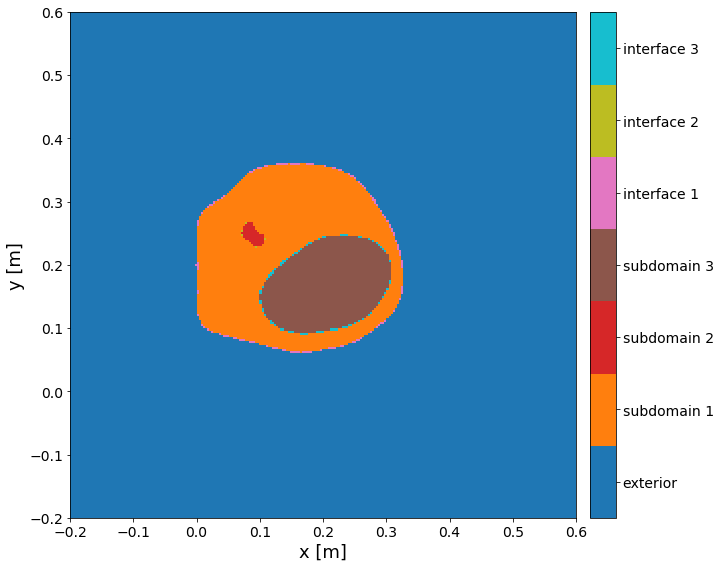

In [18]:
fig = optimus.postprocess.plot_regions(postprocess_plane)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

In [19]:
%%time
model.solve()

CPU times: user 1h 7min 38s, sys: 58min 8s, total: 2h 5min 46s
Wall time: 2min 15s


In [20]:
print("GMRES iterations: ", model.linear_solve_iteration_count)

GMRES iterations:  749


## Visualisation of the acoustic field

The acoustic field can be calculated at arbitrary points. Let us visualise the field on a grid in the above visualisation plane. We increase the default posprocesing quadrature order to 20 (default = 4), for improved accuracy of the total pressure calculation.

In [21]:
%%time
optimus.global_parameters.bem.set_quadrature_order('field', 'near', 20)
postprocess_plane.compute_fields()

CPU times: user 33min 9s, sys: 24.8 s, total: 33min 33s
Wall time: 1min 17s


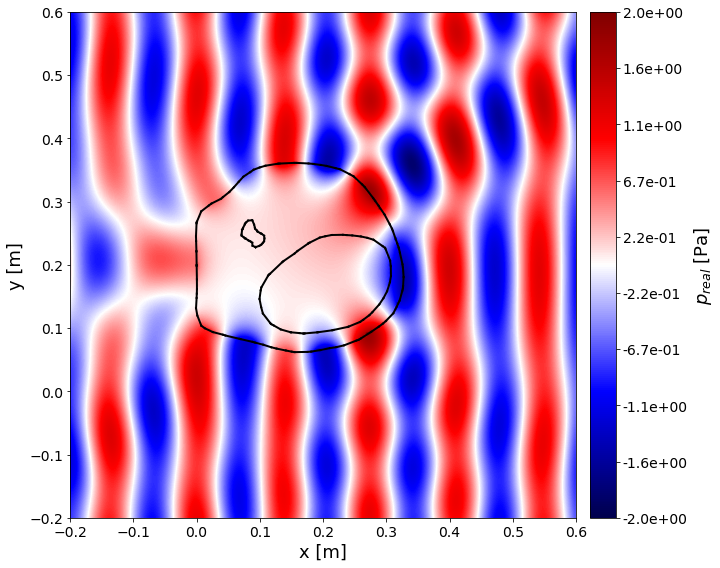

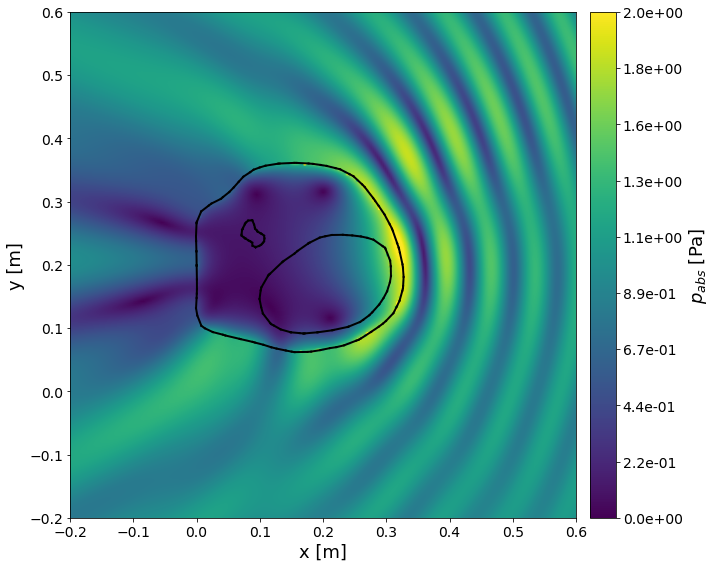

In [22]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, clim=[-2,2])